# Exercise 1 b)

In [23]:
# optimization algorithm to minimize unconstrained function
from scipy.optimize import newton
from math import sqrt
import pandas as pd
pd.options.plotting.backend = 'plotly'
import numpy as np
import matplotlib as plt

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

Function to minimize <br>
$f(x) = x_1^2 + x_2^2 + 16x_3^2$ <br>
$\nabla f(x) = (2x_1, 8x_2, 32x_3)^T$

constraint <br>
$h(x) = x_1x_2 - 1$



In [24]:
# function to minimize
f = lambda x: x[0]**2 + 4*x[1]**2 + 16*x[2]**2
# its gradient/jacobian
JacF = lambda x: [2*x[0], 8*x[1], 32*x[2]]
# norm of its gradient/jacobian
normJacF = lambda x: np.linalg.norm(JacF(x))
# constraint
h = lambda x: x[0] * x[1] - 1

# Penalty Method

$p(x) = \frac{1}{2}h(x)^Th(x) = ||h(x)||_2^2 = \frac{1}{2}(x_1x_2 - 1)^T (x_1x_2 - 1)$

$P(x,\mu) = f(x) + \mu p(x) =  x_1^2 + 4x_2^2 + 16x_3^2 + \frac{\mu}{2}(x_1x_2 - 1)^T (x_1x_2 - 1)$

In [33]:
# feasibility penalization function
p = lambda x: 0.5 * h(x)**2
# Merit function
P = lambda mu: lambda x: f(x) + mu*p(x)
JacP = lambda mu: lambda x: np.array([2*x[0] + mu*(x[0]*x[1]**2 -x[1]), 8*x[1] + mu*(x[1]*x[0]**2 -x[0]), 32*x[2]])

## minimize

In [116]:
data = pd.DataFrame(columns=['iteration','x', 'f(x)',"||f'(x)||",'P(x)','p(x)','h(x)','mu', 'mu*h(x)']).set_index('iteration')
# initial condition
i=0 # iteration
x = [20,30,15]
mu = 10

# start optimization loop
max_iter = 25
while i <= max_iter:
    data.loc[i] = [x, f(x), normJacF(x), P(mu)(x), p(x), h(x), mu, mu*h(x)]
    i += 1 
    x = newton(JacP(mu), x, maxiter=5000)
    mu *= 2
data.tail(3)

,x,f(x),||f'(x)||,P(x),p(x),h(x),mu,mu*h(x)
iteration,,,,,,,,
24,"[1.414062647378789, 0.7071822130145448, 0.0]",4,6.32496,4.0,1.136952e-15,-4.76855e-08,83886080,-4.00015
25,"[1.4140626613518636, 0.7071822228876724, 0.0]",4,6.32496,4.0,2.842379e-16,-2.38427e-08,167772160,-4.00015
26,"[1.4140626683384008, 0.7071822278242362, 0.0]",4,6.32496,4.0,7.105948e-17,-1.19214e-08,335544320,-4.00015


## Plotting 

Values to pay attention to 

In [117]:
x_star1 = (sqrt(2),1/sqrt(2),0)
x_star2 = (-sqrt(2),-1/sqrt(2),0)
print(f"{x_star1=}")
print(f"{x_star2=}")
print(f"{f(x_star1)=}")
print(f"{f(x_star2)=}")
print("Lagrangian multiplier: -4")

x_star1=(1.4142135623730951, 0.7071067811865475, 0)
x_star2=(-1.4142135623730951, -0.7071067811865475, 0)
f(x_star1)=4.0
f(x_star2)=4.0
Lagrangian multiplier: -4


How is the convergence of f(x) to the minimum?

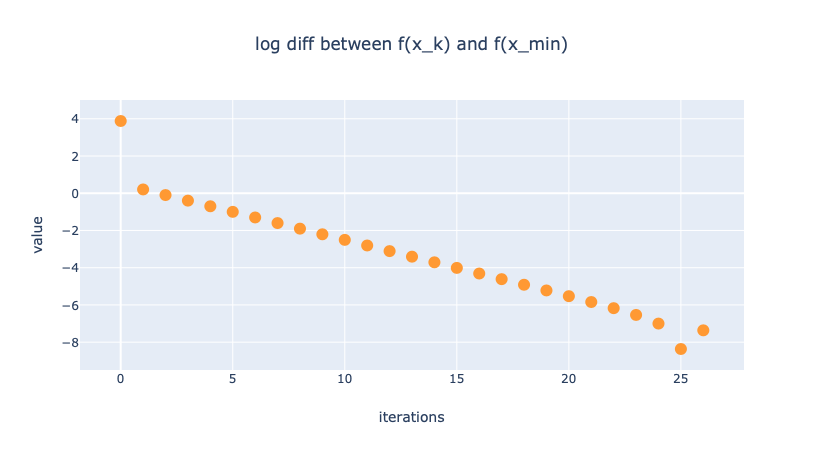

In [118]:
layout = dict(title_text='log diff between f(x_k) and f(x_min)', title_x=0.5, xaxis_title='iterations', yaxis_title='value')
log_diff = (data['f(x)']-f(x_star1)).apply(lambda x: np.log10(np.abs(x)))
log_diff.iplot(mode='markers',xTitle='iterations',yTitle='log(f(x_i)-4)',layout=layout)

Let's see if the term $\mu \cdot h(x)$ converges to the lagrange multiplier associated with this problem, which is equal to -4.

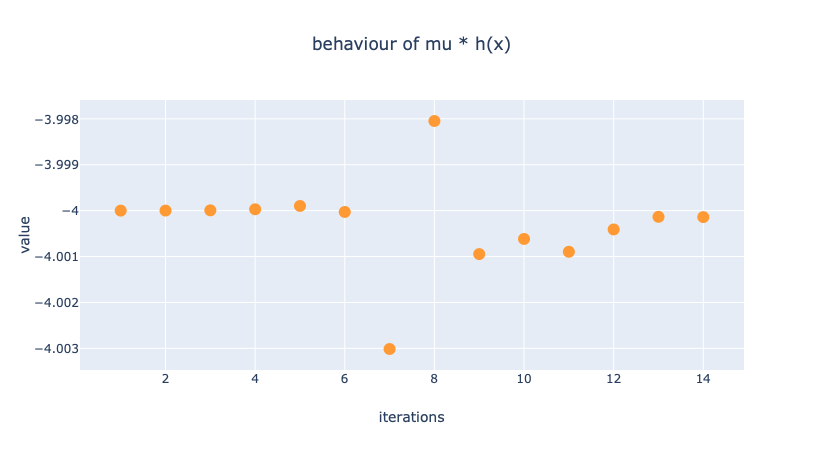

In [119]:
layout = dict(title_text='behaviour of mu * h(x)', title_x=0.5, xaxis_title='iterations', yaxis_title='value')

log_diff = data['mu*h(x)'].apply(lambda x: np.log10(np.abs(x)))
data['mu*h(x)'][1:15].iplot(mode='markers',xTitle='iterations',yTitle='mu*h(x)',layout=layout)


# Augmented Lagrangian Method

$
\begin{equation}
\begin{aligned}
L(x,\lambda,\mu) &= f(x) + \lambda^Th(x) + \frac{\mu}{2}h(x)^Th(x) \\
&= x_1^2 + x_2^2 + 16x_3^2 + \lambda^T(x_1x_2 - 1) + \frac{\mu}{2} (x_1x_2 - 1)^T (x_1x_2 - 1)
\end{aligned}
\end{equation}
$

In [25]:
# feasibility penalization function
p = lambda x: 1/2 * h(x)**2
# Merit function
L = lambda mu,lamb: lambda x: f(x) + lamb*h(x) + mu*p(x)
JacL = lambda mu,lamb: lambda x: np.array([2*x[0] + (lamb*x[1]) + mu*(x[0]*x[1]**2 -x[1]), 
                                           8*x[1] + (lamb*x[0]) + mu*(x[1]*x[0]**2 -x[0]), 32*x[2]])
normJacL = lambda mu,lamb: lambda x: np.linalg.norm(JacL(mu,lamb)(x))

## minimize

In [32]:
dataAug = pd.DataFrame(columns=['iteration','x', 'f(x)',"||f'(x)||",'L(x)',"||L'(x)||",'p(x)','h(x)','mu','lambda']).set_index('iteration')
# initial condition
j=0 # iteration
x = [20,30,15]
mu = 5 # se o mu começar em 2 já não dá!!!!
lamb = 2

# start optimization loop
max_iter = 25
while j <= max_iter: 
    dataAug.loc[j] = [x, f(x), normJacF(x), L(mu,lamb)(x),normJacL(mu,lamb)(x), p(x), h(x), mu, lamb]
    x = newton(JacL(mu,lamb), x, maxiter=10000, disp=False)
    j += 1
    mu *= 2
    lamb = lamb + mu * h(x)
dataAug.tail(5)

,x,f(x),||f'(x)||,L(x),||L'(x)||,p(x),h(x),mu,lambda
iteration,,,,,,,,,
21,"[1.4141514748448758, 0.7071372884251028, 0.0]",4,6.324718,4.000006,18.916137,2.892986e-13,-7.60656e-07,10485760,-7.98809
22,"[1.4141521432495332, 0.7071377610262188, 0.0]",4,6.324722,4.000003,18.916618,7.232466e-14,3.80328e-07,20971520,-0.0120328
23,"[1.4141518090929701, 0.7071375247028442, 0.0]",4,6.324720,4.000002,18.916141,1.808116e-14,-1.90164e-07,41943040,-7.98809
24,"[1.4141519761940942, 0.7071376428531198, 0.0]",4,6.324721,4.000001,18.916615,4.520291e-15,9.5082e-08,83886080,-0.0120329
25,"[1.4141518926549506, 0.7071375837722766, 0.0]",4,6.324721,4.000000,18.916142,1.130073e-15,-4.7541e-08,167772160,-7.98809


## Plotting

In [30]:
layout = dict(title_text='log diff between f(x_k) and f(x_min)', title_x=0.5, xaxis_title='iterations', yaxis_title='value')
log_diff = (dataAug['f(x)']-f(x_star1)).apply(lambda x: np.log10(np.abs(x)))
log_diff[1:].iplot(mode='markers',xTitle='iterations',yTitle='log(f(x_i)-4)',layout=layout)

How does the lambda estimate behave over the iterations?

In [31]:
layout = dict(title_text='lambda estimate over the iterations', title_x=0.5,xaxis_title='iterations', yaxis_title='lambda')
dataAug['lambda'].iplot(mode='markers',layout=layout)